## Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from skimage.transform import resize

import numpy as np

from torch.autograd import Variable

import torchvision.utils as vutils


%matplotlib inline

## Data loading

Num of pictures: 120


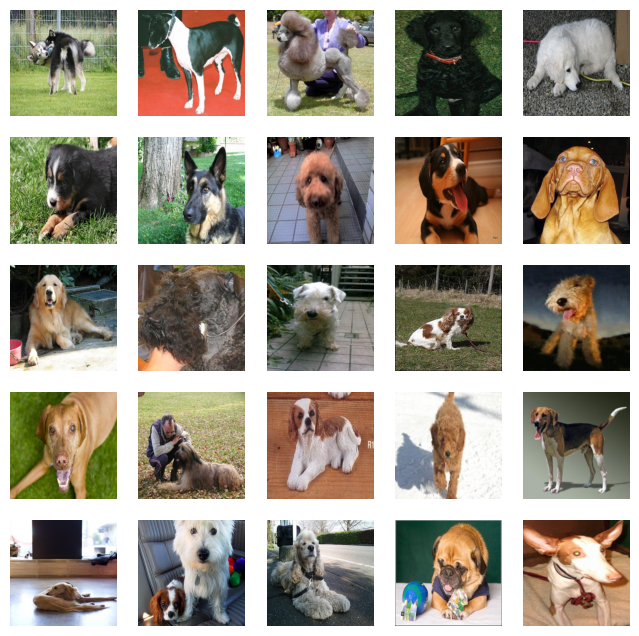

In [2]:
import random

path = '/kaggle/input/stanford-dogs-dataset/images/Images/'

images = os.listdir(path)


print(f'Num of pictures: {len(os.listdir(path))}')


fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))


for indx, axis in enumerate(axes.flatten()):
    path_choice = random.choice(os.listdir(path))

    rnd_indx = np.random.randint(0, len(os.listdir(f'{path}/{path_choice}')))
    
    images = os.listdir(f'{path}/{path_choice}/')
    img = plt.imread(f'{path}/{path_choice}/{images[rnd_indx]}')
 
    img = resize(img, (400,400))
    imgplot = axis.imshow(img)
    axis.set_axis_off()



## Data Preparation

In [3]:
batch_size = 32
image_size = 32

random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([transforms.Resize(32),
                                transforms.CenterCrop(32),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.RandomApply(random_transforms, p=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder(path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True,
                                           batch_size=batch_size)
                                           
imgs, label = next(iter(train_loader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)

## Discriminator and Generator

In [4]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        n_features = 3072
        n_out = 1
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


In [5]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        n_features = 100
        n_out = 3072

        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.ReLU()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

### Helper Functions

In [6]:
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 3, 32, 32)

def noise(size):
    n = Variable(torch.randn(size, 100))
    return n
    
def display_transposed_images_single_row(image_array):
    num_images = image_array.shape[0]

    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for j in range(5):
        image = np.transpose(image_array[j].reshape((3, 32, 32)), (1, 2, 0))
        axes[j].imshow(image)
        axes[j].axis('off')

    plt.show()

## Train functions

In [7]:
def train_discriminator(discriminator, optimizer, real_data, fake_data, loss):
    N = real_data.size(0)

    optimizer.zero_grad()

    prediction_real = discriminator(real_data)

    error_real = loss(prediction_real, Variable(torch.ones(N, 1)))
    error_real.backward()

    prediction_fake = discriminator(fake_data)

    error_fake = loss(prediction_fake, Variable(torch.zeros(N, 1)))
    error_fake.backward()

    optimizer.step()

    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(discriminator, optimizer, fake_data, loss):

    N = fake_data.size(0)  
    
    optimizer.zero_grad()  
    
    prediction = discriminator(fake_data)  
    error = loss(prediction, Variable(torch.ones(N, 1)))
    
    error.backward()  
    optimizer.step()  

    return error

## Main training loop

In [8]:

def train(discriminator, generator):
    loss_d = nn.BCELoss()
    loss_g = nn.BCELoss()
    d_optimizer = optim.Adam(discriminator.parameters(), 0.0002)
    g_optimizer = optim.Adam(generator.parameters(), 0.0002)

    data_loader= train_loader
    
    num_epochs=200
    num_batches = len(data_loader)
    
    num_test_samples = 48
    test_noise = noise(num_test_samples)
    z_dim = 100


    for epoch in range(num_epochs):
        for n_batch, data in enumerate(data_loader):

            (real_batch, labels) = data
            N = real_batch.size(0)

            # 1. Train Discriminator
            real_data = real_batch.view(real_batch.size(0), -1)

            latent_space_data = noise(N)
            fake_data = generator(latent_space_data).detach()

            d_error, d_pred_real, d_pred_fake = train_discriminator(discriminator, d_optimizer, real_data,
                                                                          fake_data,
                                                                          loss_d)
            # 2. Train Generator
            latent_space_data = noise(N)
            fake_data = generator(latent_space_data)
    
            g_error = train_generator(discriminator, g_optimizer, fake_data, loss_g)  # Log batch error

            if n_batch % 644 == 0:
                print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
                            epoch, num_epochs, n_batch, num_batches)
                    )
                print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
                print('------------------------------')
        
        if epoch % 20 == 0:
            with torch.no_grad():
                noise2 = torch.randn(25, z_dim)
                generated_images = generator(noise2).cpu().numpy()

            display_transposed_images_single_row(generated_images)

Epoch: [0/200], Batch Num: [0/644]
Discriminator Loss: 1.3728, Generator Loss: 0.6695
------------------------------


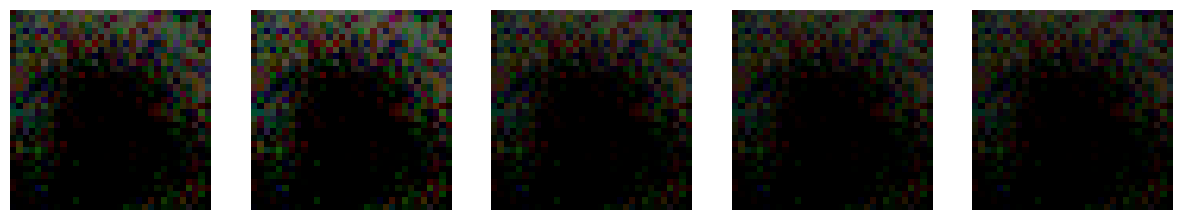

Epoch: [1/200], Batch Num: [0/644]
Discriminator Loss: 0.1659, Generator Loss: 4.7863
------------------------------
Epoch: [2/200], Batch Num: [0/644]
Discriminator Loss: 0.6399, Generator Loss: 1.6378
------------------------------
Epoch: [3/200], Batch Num: [0/644]
Discriminator Loss: 0.7144, Generator Loss: 2.3117
------------------------------
Epoch: [4/200], Batch Num: [0/644]
Discriminator Loss: 0.5757, Generator Loss: 1.8493
------------------------------
Epoch: [5/200], Batch Num: [0/644]
Discriminator Loss: 0.2189, Generator Loss: 2.9915
------------------------------
Epoch: [6/200], Batch Num: [0/644]
Discriminator Loss: 0.1662, Generator Loss: 3.6540
------------------------------
Epoch: [7/200], Batch Num: [0/644]
Discriminator Loss: 0.2886, Generator Loss: 1.9016
------------------------------
Epoch: [8/200], Batch Num: [0/644]
Discriminator Loss: 0.2923, Generator Loss: 2.3795
------------------------------
Epoch: [9/200], Batch Num: [0/644]
Discriminator Loss: 0.2876, G

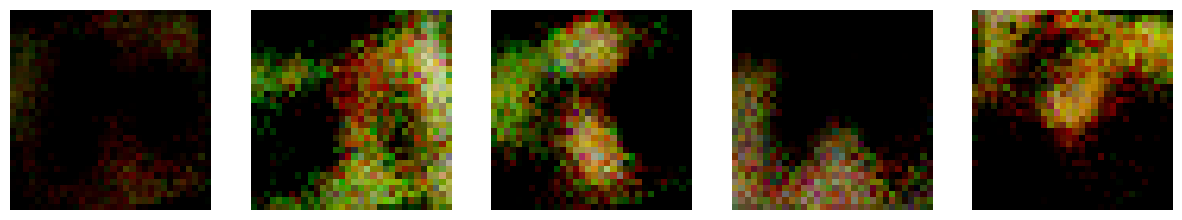

Epoch: [21/200], Batch Num: [0/644]
Discriminator Loss: 0.5458, Generator Loss: 2.3162
------------------------------
Epoch: [22/200], Batch Num: [0/644]
Discriminator Loss: 0.7928, Generator Loss: 2.4533
------------------------------
Epoch: [23/200], Batch Num: [0/644]
Discriminator Loss: 0.5021, Generator Loss: 2.5064
------------------------------
Epoch: [24/200], Batch Num: [0/644]
Discriminator Loss: 0.9741, Generator Loss: 2.2192
------------------------------
Epoch: [25/200], Batch Num: [0/644]
Discriminator Loss: 0.4019, Generator Loss: 1.9792
------------------------------
Epoch: [26/200], Batch Num: [0/644]
Discriminator Loss: 0.9128, Generator Loss: 1.6181
------------------------------
Epoch: [27/200], Batch Num: [0/644]
Discriminator Loss: 1.0777, Generator Loss: 2.0139
------------------------------
Epoch: [28/200], Batch Num: [0/644]
Discriminator Loss: 0.9024, Generator Loss: 1.6191
------------------------------
Epoch: [29/200], Batch Num: [0/644]
Discriminator Loss: 

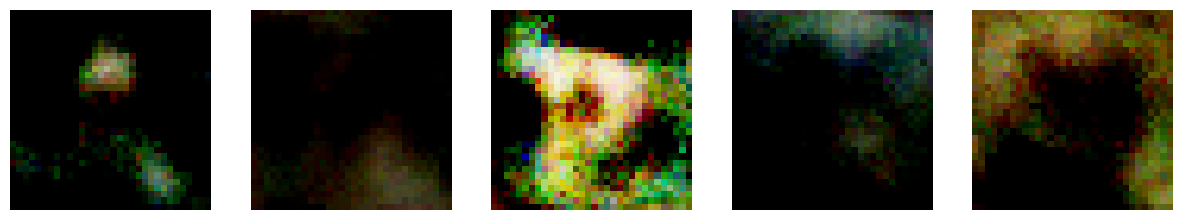

Epoch: [41/200], Batch Num: [0/644]
Discriminator Loss: 0.7944, Generator Loss: 1.4722
------------------------------
Epoch: [42/200], Batch Num: [0/644]
Discriminator Loss: 1.2599, Generator Loss: 1.1568
------------------------------
Epoch: [43/200], Batch Num: [0/644]
Discriminator Loss: 1.2161, Generator Loss: 1.0325
------------------------------
Epoch: [44/200], Batch Num: [0/644]
Discriminator Loss: 1.0814, Generator Loss: 1.3550
------------------------------
Epoch: [45/200], Batch Num: [0/644]
Discriminator Loss: 0.9030, Generator Loss: 1.3569
------------------------------
Epoch: [46/200], Batch Num: [0/644]
Discriminator Loss: 0.8312, Generator Loss: 1.2411
------------------------------
Epoch: [47/200], Batch Num: [0/644]
Discriminator Loss: 1.0730, Generator Loss: 1.3941
------------------------------
Epoch: [48/200], Batch Num: [0/644]
Discriminator Loss: 1.4435, Generator Loss: 1.2329
------------------------------
Epoch: [49/200], Batch Num: [0/644]
Discriminator Loss: 

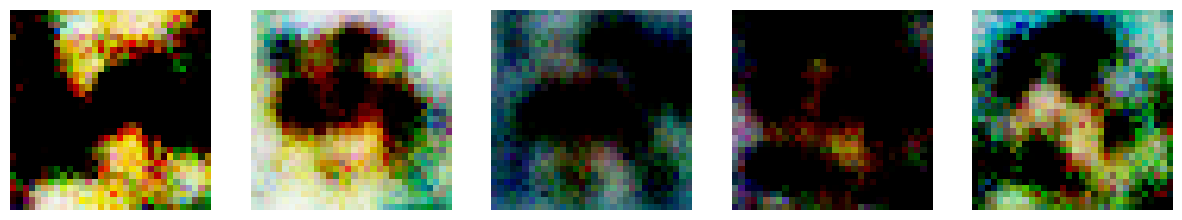

Epoch: [61/200], Batch Num: [0/644]
Discriminator Loss: 1.3960, Generator Loss: 1.0698
------------------------------
Epoch: [62/200], Batch Num: [0/644]
Discriminator Loss: 1.2304, Generator Loss: 0.8903
------------------------------
Epoch: [63/200], Batch Num: [0/644]
Discriminator Loss: 1.1601, Generator Loss: 0.9347
------------------------------
Epoch: [64/200], Batch Num: [0/644]
Discriminator Loss: 1.1656, Generator Loss: 1.1580
------------------------------
Epoch: [65/200], Batch Num: [0/644]
Discriminator Loss: 1.2217, Generator Loss: 1.2318
------------------------------
Epoch: [66/200], Batch Num: [0/644]
Discriminator Loss: 1.0773, Generator Loss: 1.1351
------------------------------
Epoch: [67/200], Batch Num: [0/644]
Discriminator Loss: 1.2983, Generator Loss: 0.9608
------------------------------
Epoch: [68/200], Batch Num: [0/644]
Discriminator Loss: 1.2512, Generator Loss: 0.9804
------------------------------
Epoch: [69/200], Batch Num: [0/644]
Discriminator Loss: 

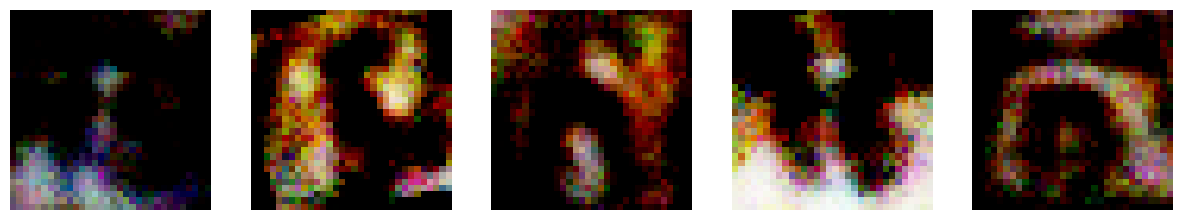

Epoch: [81/200], Batch Num: [0/644]
Discriminator Loss: 1.1470, Generator Loss: 1.0488
------------------------------
Epoch: [82/200], Batch Num: [0/644]
Discriminator Loss: 1.0668, Generator Loss: 0.9594
------------------------------
Epoch: [83/200], Batch Num: [0/644]
Discriminator Loss: 1.2337, Generator Loss: 0.9171
------------------------------
Epoch: [84/200], Batch Num: [0/644]
Discriminator Loss: 1.2279, Generator Loss: 0.9726
------------------------------
Epoch: [85/200], Batch Num: [0/644]
Discriminator Loss: 1.1285, Generator Loss: 0.8634
------------------------------
Epoch: [86/200], Batch Num: [0/644]
Discriminator Loss: 1.2764, Generator Loss: 1.3082
------------------------------
Epoch: [87/200], Batch Num: [0/644]
Discriminator Loss: 1.3093, Generator Loss: 0.8633
------------------------------
Epoch: [88/200], Batch Num: [0/644]
Discriminator Loss: 1.1936, Generator Loss: 0.9236
------------------------------
Epoch: [89/200], Batch Num: [0/644]
Discriminator Loss: 

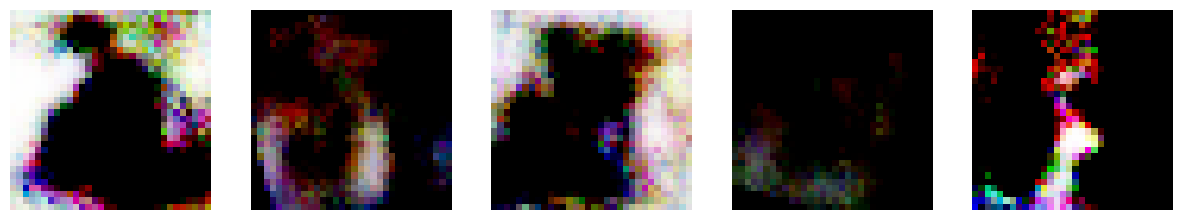

Epoch: [101/200], Batch Num: [0/644]
Discriminator Loss: 1.3449, Generator Loss: 0.9084
------------------------------
Epoch: [102/200], Batch Num: [0/644]
Discriminator Loss: 1.1811, Generator Loss: 0.8907
------------------------------
Epoch: [103/200], Batch Num: [0/644]
Discriminator Loss: 1.3741, Generator Loss: 0.8765
------------------------------
Epoch: [104/200], Batch Num: [0/644]
Discriminator Loss: 1.3865, Generator Loss: 0.8788
------------------------------
Epoch: [105/200], Batch Num: [0/644]
Discriminator Loss: 1.3746, Generator Loss: 1.0411
------------------------------
Epoch: [106/200], Batch Num: [0/644]
Discriminator Loss: 1.1539, Generator Loss: 0.8634
------------------------------
Epoch: [107/200], Batch Num: [0/644]
Discriminator Loss: 1.1566, Generator Loss: 0.9015
------------------------------
Epoch: [108/200], Batch Num: [0/644]
Discriminator Loss: 1.0215, Generator Loss: 1.0569
------------------------------
Epoch: [109/200], Batch Num: [0/644]
Discriminat

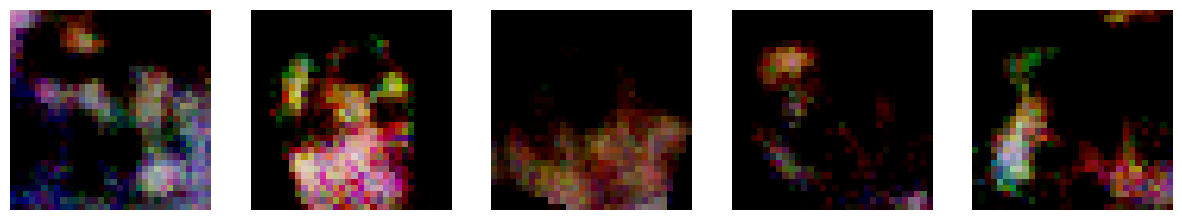

Epoch: [121/200], Batch Num: [0/644]
Discriminator Loss: 1.2672, Generator Loss: 0.8343
------------------------------
Epoch: [122/200], Batch Num: [0/644]
Discriminator Loss: 1.4008, Generator Loss: 0.8716
------------------------------
Epoch: [123/200], Batch Num: [0/644]
Discriminator Loss: 1.3636, Generator Loss: 0.7831
------------------------------
Epoch: [124/200], Batch Num: [0/644]
Discriminator Loss: 1.3543, Generator Loss: 0.8289
------------------------------
Epoch: [125/200], Batch Num: [0/644]
Discriminator Loss: 1.4491, Generator Loss: 0.8085
------------------------------
Epoch: [126/200], Batch Num: [0/644]
Discriminator Loss: 1.3161, Generator Loss: 0.7719
------------------------------
Epoch: [127/200], Batch Num: [0/644]
Discriminator Loss: 1.1813, Generator Loss: 1.0026
------------------------------
Epoch: [128/200], Batch Num: [0/644]
Discriminator Loss: 1.4241, Generator Loss: 0.8959
------------------------------
Epoch: [129/200], Batch Num: [0/644]
Discriminat

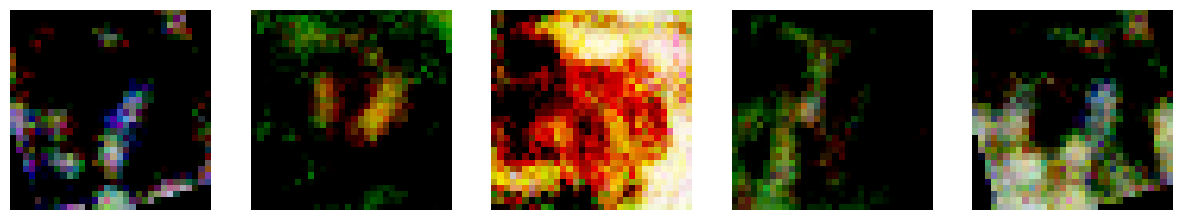

Epoch: [141/200], Batch Num: [0/644]
Discriminator Loss: 1.1090, Generator Loss: 0.9118
------------------------------
Epoch: [142/200], Batch Num: [0/644]
Discriminator Loss: 1.3565, Generator Loss: 0.7678
------------------------------
Epoch: [143/200], Batch Num: [0/644]
Discriminator Loss: 1.2686, Generator Loss: 0.8828
------------------------------
Epoch: [144/200], Batch Num: [0/644]
Discriminator Loss: 1.3785, Generator Loss: 0.8002
------------------------------
Epoch: [145/200], Batch Num: [0/644]
Discriminator Loss: 1.2149, Generator Loss: 0.8057
------------------------------
Epoch: [146/200], Batch Num: [0/644]
Discriminator Loss: 1.3871, Generator Loss: 0.8016
------------------------------
Epoch: [147/200], Batch Num: [0/644]
Discriminator Loss: 1.3241, Generator Loss: 0.9434
------------------------------
Epoch: [148/200], Batch Num: [0/644]
Discriminator Loss: 1.3094, Generator Loss: 0.8033
------------------------------
Epoch: [149/200], Batch Num: [0/644]
Discriminat

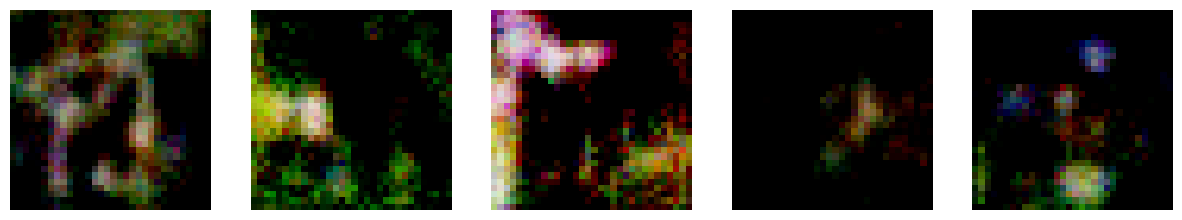

Epoch: [161/200], Batch Num: [0/644]
Discriminator Loss: 1.4882, Generator Loss: 0.8402
------------------------------
Epoch: [162/200], Batch Num: [0/644]
Discriminator Loss: 1.4779, Generator Loss: 0.8517
------------------------------
Epoch: [163/200], Batch Num: [0/644]
Discriminator Loss: 1.3063, Generator Loss: 0.8380
------------------------------
Epoch: [164/200], Batch Num: [0/644]
Discriminator Loss: 1.3052, Generator Loss: 1.0283
------------------------------
Epoch: [165/200], Batch Num: [0/644]
Discriminator Loss: 1.3285, Generator Loss: 0.8905
------------------------------
Epoch: [166/200], Batch Num: [0/644]
Discriminator Loss: 1.4525, Generator Loss: 0.8345
------------------------------
Epoch: [167/200], Batch Num: [0/644]
Discriminator Loss: 1.1411, Generator Loss: 0.7888
------------------------------
Epoch: [168/200], Batch Num: [0/644]
Discriminator Loss: 1.2326, Generator Loss: 0.9188
------------------------------
Epoch: [169/200], Batch Num: [0/644]
Discriminat

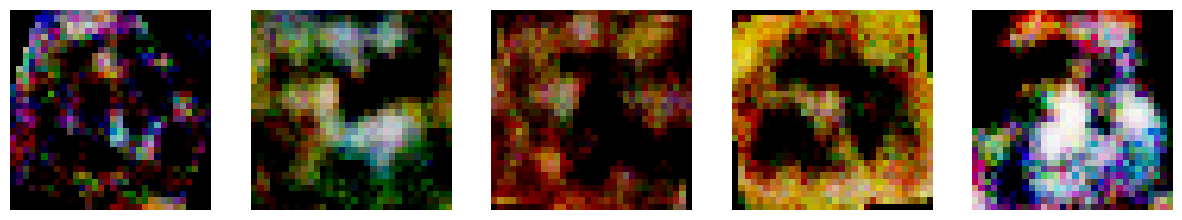

Epoch: [181/200], Batch Num: [0/644]
Discriminator Loss: 1.3154, Generator Loss: 0.7228
------------------------------
Epoch: [182/200], Batch Num: [0/644]
Discriminator Loss: 1.4023, Generator Loss: 0.8414
------------------------------
Epoch: [183/200], Batch Num: [0/644]
Discriminator Loss: 1.3516, Generator Loss: 0.7746
------------------------------
Epoch: [184/200], Batch Num: [0/644]
Discriminator Loss: 1.5061, Generator Loss: 0.8905
------------------------------
Epoch: [185/200], Batch Num: [0/644]
Discriminator Loss: 1.3926, Generator Loss: 0.7733
------------------------------
Epoch: [186/200], Batch Num: [0/644]
Discriminator Loss: 1.3770, Generator Loss: 0.7618
------------------------------
Epoch: [187/200], Batch Num: [0/644]
Discriminator Loss: 1.1942, Generator Loss: 0.8853
------------------------------
Epoch: [188/200], Batch Num: [0/644]
Discriminator Loss: 1.1836, Generator Loss: 0.9437
------------------------------
Epoch: [189/200], Batch Num: [0/644]
Discriminat

In [9]:
D = Discriminator()
G = Generator()
train(D, G)

## Evaluation of a model

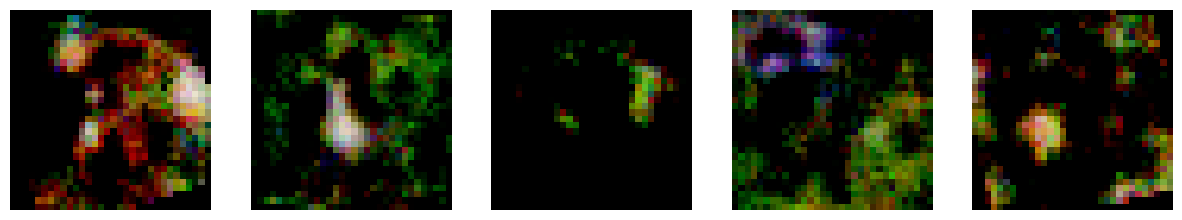

In [10]:
def evaluate(generator, num_samples=100):
    z_dim = 100
    with torch.no_grad():
        noise_eval = torch.randn(num_samples, z_dim)
        generated_images = generator(noise_eval).cpu().numpy()

    display_transposed_images_single_row(generated_images)


evaluate(G)
